In [1]:
import sys
sys.path.append("../")
from BinaryCliffordClassifier import *
from BinaryClassifier import *
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

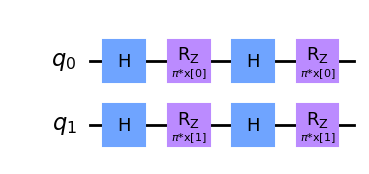

In [2]:
### Set up the encoder
X=ParameterVector('x',2)
encoder  = QuantumCircuit(2)
encoder.h([0,1])
encoder.rz(np.pi * X[0],0)
encoder.rz(np.pi * X[1],1)
encoder=encoder.compose(encoder)
encoder.draw(output='mpl',fold=-1)

0
10
20
30
40
50
60
70
80
90


Text(0.5, 1.0, 'Fidelity Plot')

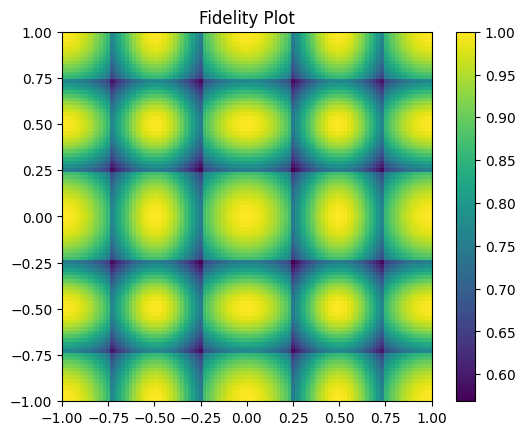

In [3]:
### Clifford Fidelity Benchmarking
A=np.zeros((100,100))
for i,x0 in enumerate(np.linspace(-1,1,100)):
    for j,x1 in enumerate(np.linspace(-1,1,100)):
        s1=Statevector(encoder.assign_parameters([x0,x1]))
        s2=Statevector(Cliffordize(encoder.assign_parameters([x0,x1])))
        A[i][j]=abs(s1.inner(s2))**2
    if(i%10==0):
        print(i)
plt.imshow(A.T,extent=[-1,1,-1,1],origin='lower')
plt.colorbar()
plt.title("Fidelity Plot")

In [4]:
print("Average Input Fidelity " +str(np.mean(A)))

Average Input Fidelity 0.8646169414543601


In [5]:
from scipy.linalg import qr
from qiskit.quantum_info import Operator, SparsePauliOp
##Generate an n-point Test set and an n-point Training set
def generateData(delta,n):
    
    #random 4x4 Unitary 
    H = (np.random.randn(4, 4)+1j*np.random.randn(4, 4))/np.sqrt(2)
    Q, R = qr(H)
    R = np.diag(np.diag(R)/abs(np.diag(R)))
    U=Q.dot(R)
    V=Operator(U)
    
    #Pairity Function
    f = SparsePauliOp('ZZ').to_matrix()
    
    
    #Populate the data sets
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    while(len(train_x) < n or len(test_x )< n):
        
        x  = 2*np.random.random(2)-1 
        temp_qc = encoder.assign_parameters(x)
        val = Statevector(temp_qc).expectation_value(V.adjoint()@f@V).real
        if(val<-delta and len(train_x) < n and train_y.count(-1)< n//2):
            train_x.append(x)
            train_y.append(-1)
        elif(val>delta and len(train_x) < n and train_y.count(1)< n//2):
            train_x.append(x)
            train_y.append(1)
        
        x  = 2*np.random.random(2)-1
        temp_qc = encoder.assign_parameters(x)
        val = Statevector(temp_qc).expectation_value(V.adjoint()@f@V).real
        if(val<-delta and len(test_x )< n and test_y.count(-1)< n//2):
            test_x.append(x)
            test_y.append(-1)
        elif(val>delta and len(test_x )< n and test_y.count(1)< n//2):
            test_x.append(x)
            test_y.append(1)
    return test_x,test_y, train_x,train_y, V

In [6]:
### Generate the dataset
test_x,test_y,train_x,train_y,V = generateData(0.3,100)

print("Training Data:")
print("Plus: "+str(len([i for i in train_y if i==1])))
print("Minus: "+str(len([i for i in train_y if i==-1])))
print("------------")
print("Test Data:")
print("Plus: "+str(len([i for i in test_y if i==1])))
print("Minus: "+str(len([i for i in test_y if i==-1])))


Training Data:
Plus: 50
Minus: 50
------------
Test Data:
Plus: 50
Minus: 50


Background 0% complete
Background 10% complete
Background 20% complete
Background 30% complete
Background 40% complete
Background 50% complete
Background 60% complete
Background 70% complete
Background 80% complete
Background 90% complete


[Text(0.5, 1.0, 'Testing Data')]

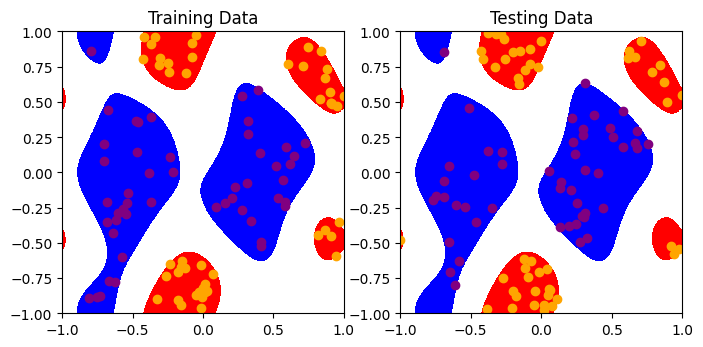

In [7]:
### Plot dataset
test_plus = [x for i,x in enumerate(test_x) if test_y[i]==1]
test_minus = [x for i,x in enumerate(test_x) if test_y[i]==-1]
train_plus = [x for i,x in enumerate(train_x) if train_y[i]==1]
train_minus = [x for i,x in enumerate(train_x) if train_y[i]==-1]

A = np.zeros((100,100))
for i,x in enumerate(np.linspace(-1,1,100)):
    for j,y in enumerate(np.linspace(-1,1,100)):
        temp_qc = encoder.assign_parameters([x,y])
        f=SparsePauliOp('ZZ').to_matrix()
        A[i][j] =  Statevector(temp_qc).expectation_value(V.adjoint()@f@V).real  
    if(i%10==0):
        print("Background "+str(i)+"% complete")
from matplotlib import colors
cmap = colors.ListedColormap(['blue','white','red'])
bounds=[-1,-0.3,0.3,1]
norm = colors.BoundaryNorm(bounds, cmap.N)


fig, axs = plt.subplots(1, 2,figsize=(8,4))


axs[0].imshow(A.T,cmap=cmap,interpolation='gaussian',norm=norm,extent=[-1,1,-1,1],origin='lower')
axs[0].scatter(np.array(train_plus).T[0],np.array(train_plus).T[1],color='orange')
axs[0].scatter(np.array(train_minus).T[0],np.array(train_minus).T[1],color='purple')
axs[0].set(title='Training Data')

axs[1].imshow(A.T,cmap=cmap,interpolation='gaussian',norm=norm,extent=[-1,1,-1,1],origin='lower')
axs[1].scatter(np.array(test_plus).T[0],np.array(test_plus).T[1],color='orange')
axs[1].scatter(np.array(test_minus).T[0],np.array(test_minus).T[1],color='purple')
axs[1].set(title='Testing Data')

In [8]:
def getClassifier(layers=3):
    Classifier=QuantumCircuit(2)
    Theta = ParameterVector('θ', 4 * layers)
    for i in range(layers):
        Classifier.ry(Theta[4*i],0)
        Classifier.ry(Theta[4*i+1],1)
        Classifier.rz(Theta[4*i+2],0)
        Classifier.rz(Theta[4*i+3],1)
        if(i<layers-1):
            Classifier.cx(0,1)
    return Classifier
classifier = getClassifier(5)

In [9]:
val,params = VQC_optimize(train_x=train_x,train_y=train_y,classifier=classifier,encoder=encoder,iterations=100,save_dir="Log",name='KernelB')
theta = np.array(params)*np.pi/2



[Text(0.5, 1.0, 'Testing Data (Predicted)')]

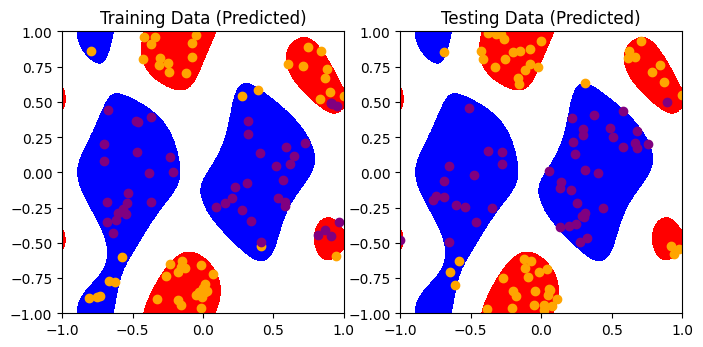

In [10]:
pred_test_plus,pred_test_minus,pred_train_plus,pred_train_minus=predictions(classifier,encoder,theta,train_x,test_x)

fig, axs = plt.subplots(1, 2,figsize=(8,4))


axs[0].imshow(A.T,cmap=cmap,interpolation='gaussian',norm=norm,extent=[-1,1,-1,1],origin='lower')
axs[0].scatter(np.array(pred_train_plus).T[0],np.array(pred_train_plus).T[1],color='orange')
axs[0].scatter(np.array(pred_train_minus).T[0],np.array(pred_train_minus).T[1],color='purple')
axs[0].set(title='Training Data (Predicted)')

axs[1].imshow(A.T,cmap=cmap,interpolation='gaussian',norm=norm,extent=[-1,1,-1,1],origin='lower')
axs[1].scatter(np.array(pred_test_plus).T[0],np.array(pred_test_plus).T[1],color='orange')
axs[1].scatter(np.array(pred_test_minus).T[0],np.array(pred_test_minus).T[1],color='purple')
axs[1].set(title='Testing Data (Predicted)')

In [11]:
acc = accuracy(classifier,encoder,theta,train_x,test_x,train_y,test_y)
print("CAFQA Training Accuracy: "+str(acc[0]))
print("CAFQA Test Accuracy: "+str(acc[1]))
loss = exactLosses(classifier,encoder,theta,train_x,test_x,train_y,test_y)
print("CAFQA Training Loss: "+str(loss[0]))
print("CAFQA Test Loss: "+str(loss[1]))


CAFQA Training Accuracy: 0.82
CAFQA Test Accuracy: 0.93
CAFQA Training Loss: 24.525046658248463
CAFQA Test Loss: 50.693522148872084
